# 새 모델 테스트
## 방법
1. 유저 카테고리 선호도를 분산/표준편차를 구한다.
2. 분산이 높은 순으로 나열.
3. 임의의 방법으로 해당 선호도를 x,y좌표계로 변환.
4. 성별은 z축이 되어 구분됨.
5. sequential 모델에 train
6. 좌표 - 선호 카테고리 간의 상관관계 학습,
7. profit!

In [18]:
import json
import sys
import numpy as np
import pandas as pd

userdata = json.loads('{\"USER_CODE\":39,\"USER_TASTE\":\"0,22\"}')
postdata = json.loads('[{\"NOTICEBOARD_NUM\":8,\"LABELS\":null},{\"NOTICEBOARD_NUM\":9,\"LABELS\":null},{\"NOTICEBOARD_NUM\":10,\"LABELS\":null},{\"NOTICEBOARD_NUM\":11,\"LABELS\":\"1\"},{\"NOTICEBOARD_NUM\":12,\"LABELS\":null},{\"NOTICEBOARD_NUM\":13,\"LABELS\":null},{\"NOTICEBOARD_NUM\":14,\"LABELS\":null},{\"NOTICEBOARD_NUM\":15,\"LABELS\":null},{\"NOTICEBOARD_NUM\":16,\"LABELS\":\"1\"}]')

label_leng = 29
print(type(postdata))

post_df = pd.DataFrame(postdata)
print(post_df['NOTICEBOARD_NUM'])
post_df

<class 'list'>
0     8
1     9
2    10
3    11
4    12
5    13
6    14
7    15
8    16
Name: NOTICEBOARD_NUM, dtype: int64


,NOTICEBOARD_NUM,LABELS
0,8,None
1,9,None
2,10,None
3,11,1
4,12,None
5,13,None
6,14,None
7,15,None
8,16,1


In [38]:
print(post_df.loc[0])
temp = np.zeros(label_leng)
if post_df.loc[0]["LABELS"] is not None:
    for ch in post_df.loc[0]["LABELS"].split(',') :
        temp[int(ch)-1] = 1
else :
    num_by_label = pd.DataFrame({post_df.loc[0]["NOTICEBOARD_NUM"] : temp})


for i in range(1, post_df.size):
    pass
    

NOTICEBOARD_NUM       8
LABELS             None
Name: 0, dtype: object


,8
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [24]:
user_taste_row = np.zeros(29)
user_taste = userdata['USER_TASTE'].split(',')
user_taste = [int(taste) for taste in user_taste]

for i in user_taste:
    user_taste_row[i] = 1

user_taste_df = pd.DataFrame({userdata['USER_CODE'] : user_taste_row})
user_taste_df = user_taste_df.T
user_taste_df


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
import numpy as np
var_arr = np.array([np.var(df.loc[:, "휴양"]), np.var(df.loc[:, "자연경관"]), np.var(df.loc[:, "문화유산"]), np.var(df.loc[:, "액티비티"]), np.var(df.loc[:, "쇼핑"]), np.var(df.loc[:, "공연"]), np.var(df.loc[:, "전시물"])])
var_arr
# 2,6,3,5,4,1,0
#x = 2 * 3 * 4/ y = 6 * 5 * 1

array([0.65870907, 1.19300932, 1.74802937, 1.44434935, 1.23363812,
       1.41498131, 1.59938741])

In [4]:
gender_data = df.loc[:, '성별']
want_data = df.loc[:, '경험']
#exp_data = df.loc[:, '경험']
personal_data = np.zeros(shape = (gender_data.size, 7))

for i in range(gender_data.size):
    for j in range(1, df.loc[i].size - 1):
        personal_data[i][j-1] = df.iloc[i][j]
        

In [51]:
new_input = np.zeros(shape = (gender_data.size, 3))
for i in range(gender_data.size):
    xpos = (personal_data[i][2] * 25 + personal_data[i][3]*5 + personal_data[i][4])/155
    ypos = (personal_data[i][6] * 25 + personal_data[i][5]*5 + personal_data[i][1])/155
    new_input[i] = np.array([xpos, ypos, 0 if gender_data[i] == '여성' else 1])
    

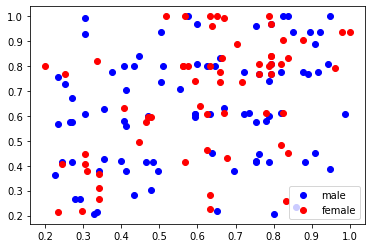

In [52]:
import matplotlib.pyplot as plt

male_x = []
male_y = []
female_x = []
female_y = []

for i in range(gender_data.size):
    if new_input[i, 2] == 0:
        female_x.append(new_input[i, 0])
        female_y.append(new_input[i, 1])
    else :
        male_x.append(new_input[i, 0])
        male_y.append(new_input[i, 1])
        
plt.scatter(male_x, male_y, color = "blue", label = "male")
plt.scatter(female_x, female_y, color = "red", label = "female")
plt.legend()
plt.show()

In [53]:
from ast import literal_eval
dataset = []
target = pd.read_csv("./survey_norm.csv")

for i in range(target['input_data'].size):
    dataset.append( [new_input[i]
                     , np.array(literal_eval(target['want_hot_vec'][i].replace(' ', ',').replace(',,', ',')), dtype = int)])

In [54]:
import random
random.shuffle(dataset)

In [55]:
train_set = dataset[:-30]
test_set = dataset[-30:]

train_input = []
train_target = []

test_input = []
test_target = []
for i in range(len(train_set)):
    train_input.append(train_set[i][0].copy())
    train_target.append(train_set[i][1].copy())

train_input = np.array(train_input)
train_target = np.array(train_target)

for i in range(len(test_set)):
    test_input.append(test_set[i][0].copy())
    test_target.append(test_set[i][1].copy())

test_input = np.array(test_input)
test_target = np.array(test_target)

In [56]:
import tensorflow as tf
from keras import models 
from keras import layers
from keras import regularizers

def build_model(train_len):
    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'relu', input_shape = (train_len, )))
    #model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(7, activation = 'sigmoid'))
    
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), "accuracy"])
    #model.compile(optimizer = 'adam', loss='mse', metrics=['accuracy'])
    return model

In [57]:
k = 4
num_val_sample = len(train_input) // k
num_epochs = 200
all_mae_histories = []
all_acc_histories = []
np.random.shuffle(train_input)
for i in range(k):
    val_input = train_input[i * num_val_sample : (i+1) * num_val_sample]
    val_target = train_target[i * num_val_sample : (i+1) * num_val_sample]
    
    partial_train_input = np.concatenate(
        [train_input[:i * num_val_sample],
         train_input[(i + 1) * num_val_sample:]], axis = 0)
    partial_train_target = np.concatenate(
        [train_target[:i * num_val_sample],
         train_target[(i + 1) * num_val_sample:]], axis = 0)
    
    model = build_model(partial_train_input.shape[1])
    history = model.fit(partial_train_input, partial_train_target, 
                        validation_data = (val_input, val_target), epochs = num_epochs, 
              batch_size = 4, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    all_acc_histories.append(history.history['accuracy'])

In [58]:
average_mae_history = [np.mean([x[i] for  x in all_mae_histories]) for i in range(num_epochs)]

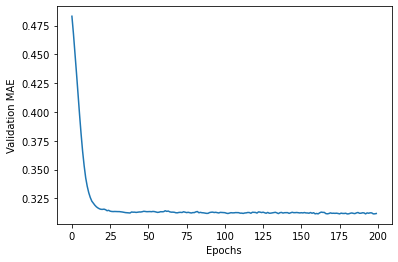

In [59]:
#smooth_mae_history = smooth_curve(average_mae_history[10:])

#plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

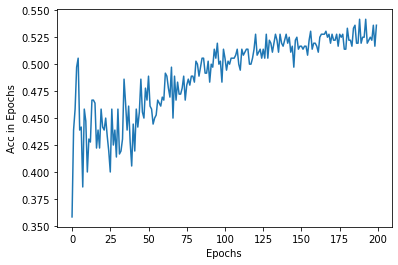

In [60]:
average_acc_history = [np.mean([x[i] for  x in all_acc_histories]) for i in range(num_epochs)]
plt.plot(range(num_epochs), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Acc in Epochs')
plt.show()

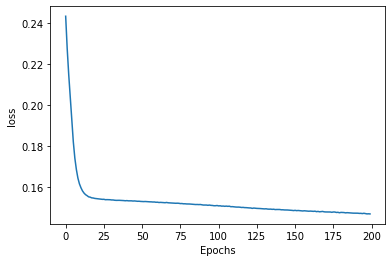

In [61]:
history_dict = history.history

plt.plot(range(num_epochs), history_dict['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [62]:
model = build_model(train_input.shape[1])
model.fit(train_input, train_target, epochs = 100, batch_size = 4, verbose = 0)
test_mse, test_mae, test_acc = model.evaluate(test_input, test_target)
print(test_mse, test_mae)

1/1 [==============================] - 0s 150ms/step - loss: 0.1809 - mean_absolute_error: 0.3318 - accuracy: 0.3667
0.18092651665210724 0.33175748586654663


In [63]:
result_df = pd.DataFrame(columns = ['input_data', 'target', 'result'])
pred_result = model.predict(test_input)

for i in range(pred_result.shape[0]):
    result_df.loc[i] = [test_input[i], test_target[i], pred_result[i]]

In [68]:
last_out = []
for i in range(pred_result.shape[0]):
    temp = []
    for j in range(pred_result.shape[1]):
        if pred_result[i][j] > 0.5:
            temp.append(1)
        else:
            temp.append(0)
            
    if np.all(np.array(temp) == 0):
        temp[np.argmax(np.array(temp))] = 1
        
    last_out.append(temp)
last_out = np.array(last_out)

In [72]:
pred_result

array([[0.50393605, 0.68252486, 0.158999  , 0.13044205, 0.21668208,
        0.00987455, 0.08377087],
       [0.76834273, 0.52701575, 0.26360577, 0.18513498, 0.14501232,
        0.00684854, 0.11742595],
       [0.6544567 , 0.55499053, 0.24579534, 0.13969803, 0.16330013,
        0.00679135, 0.11508116],
       [0.5751562 , 0.61710304, 0.22671536, 0.23842615, 0.2297529 ,
        0.03076273, 0.13127139],
       [0.5711691 , 0.60884   , 0.23889747, 0.25342545, 0.24372733,
        0.03810561, 0.14451993],
       [0.44881445, 0.72612196, 0.13206708, 0.12612963, 0.23589805,
        0.01083326, 0.07267252],
       [0.7782321 , 0.5149576 , 0.2895429 , 0.20601094, 0.16348258,
        0.00896132, 0.13729545],
       [0.72768193, 0.52088   , 0.3243248 , 0.26816022, 0.22340411,
        0.02562201, 0.18566585],
       [0.65323305, 0.53377235, 0.27346197, 0.15772241, 0.18061352,
        0.00980482, 0.13784385],
       [0.56473917, 0.6479776 , 0.17468429, 0.12123477, 0.18100107,
        0.00648978, 0.0

In [69]:
collect_cnt = 0
for i in range(pred_result.shape[0]):
    for j in range(pred_result.shape[1]):
        if last_out[i][j] == test_target[i][j]:
            collect_cnt += 1

In [70]:
print((collect_cnt / 210) * 100)

75.23809523809524


In [71]:
for i in range(pred_result.shape[0]):
    print(test_input[i], ', ', test_target[i], ', ', last_out[i])

[0.75483871 0.41290323 1.        ] ,  [1 1 0 0 1 0 0] ,  [1 1 0 0 0 0 0]
[0.78709677 1.         0.        ] ,  [1 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.50322581 0.93548387 1.        ] ,  [1 1 1 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.67741935 0.43225806 0.        ] ,  [1 0 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.56774194 0.41290323 0.        ] ,  [1 0 0 0 1 0 0] ,  [1 1 0 0 0 0 0]
[0.85806452 0.23225806 1.        ] ,  [1 0 1 0 1 0 0] ,  [0 1 0 0 0 0 0]
[0.56774194 1.         0.        ] ,  [1 1 0 0 0 1 0] ,  [1 1 0 0 0 0 0]
[0.2 0.8 0. ] ,  [0 1 0 0 0 0 1] ,  [1 1 0 0 0 0 0]
[0.30322581 0.92903226 1.        ] ,  [1 0 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.81935484 0.61290323 1.        ] ,  [0 1 1 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.83870968 0.83225806 0.        ] ,  [0 0 0 0 1 0 0] ,  [1 1 0 0 0 0 0]
[0.75483871 0.41935484 1.        ] ,  [1 1 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.22580645 0.36129032 1.        ] ,  [0 0 0 0 1 0 0] ,  [0 1 0 0 0 0 0]
[0.63225806 0.60645161 1.        ] ,  [0 1 0 1 0 0 0] ,  [1 1 0 0 0 0 0]